# **Problem statement:**

 To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
data_dir_test

PosixPath('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
!pwd

/content


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123
num_classes = 9
epochs = 20

Use 80% of the images for training, and 20% for validation.

In [ ]:
# Taining Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='training',
    batch_size = batch_size,
    image_size = (img_height,img_width),
    seed = seed
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='validation',
    batch_size = batch_size,
    image_size = (img_height,img_width),
    seed = seed
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
print(f"Number of Tranning samples: {len(train_ds.file_paths)}")
print(f"Number of Validation samples: {len(val_ds.file_paths)}")

Number of Tranning samples: 1792
Number of Validation samples: 447


In [ ]:
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), depth=9)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), depth=9)))

In [ ]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

### Visualize the data
#### Creating a code to visualize one instance of all the nine classes present in the dataset

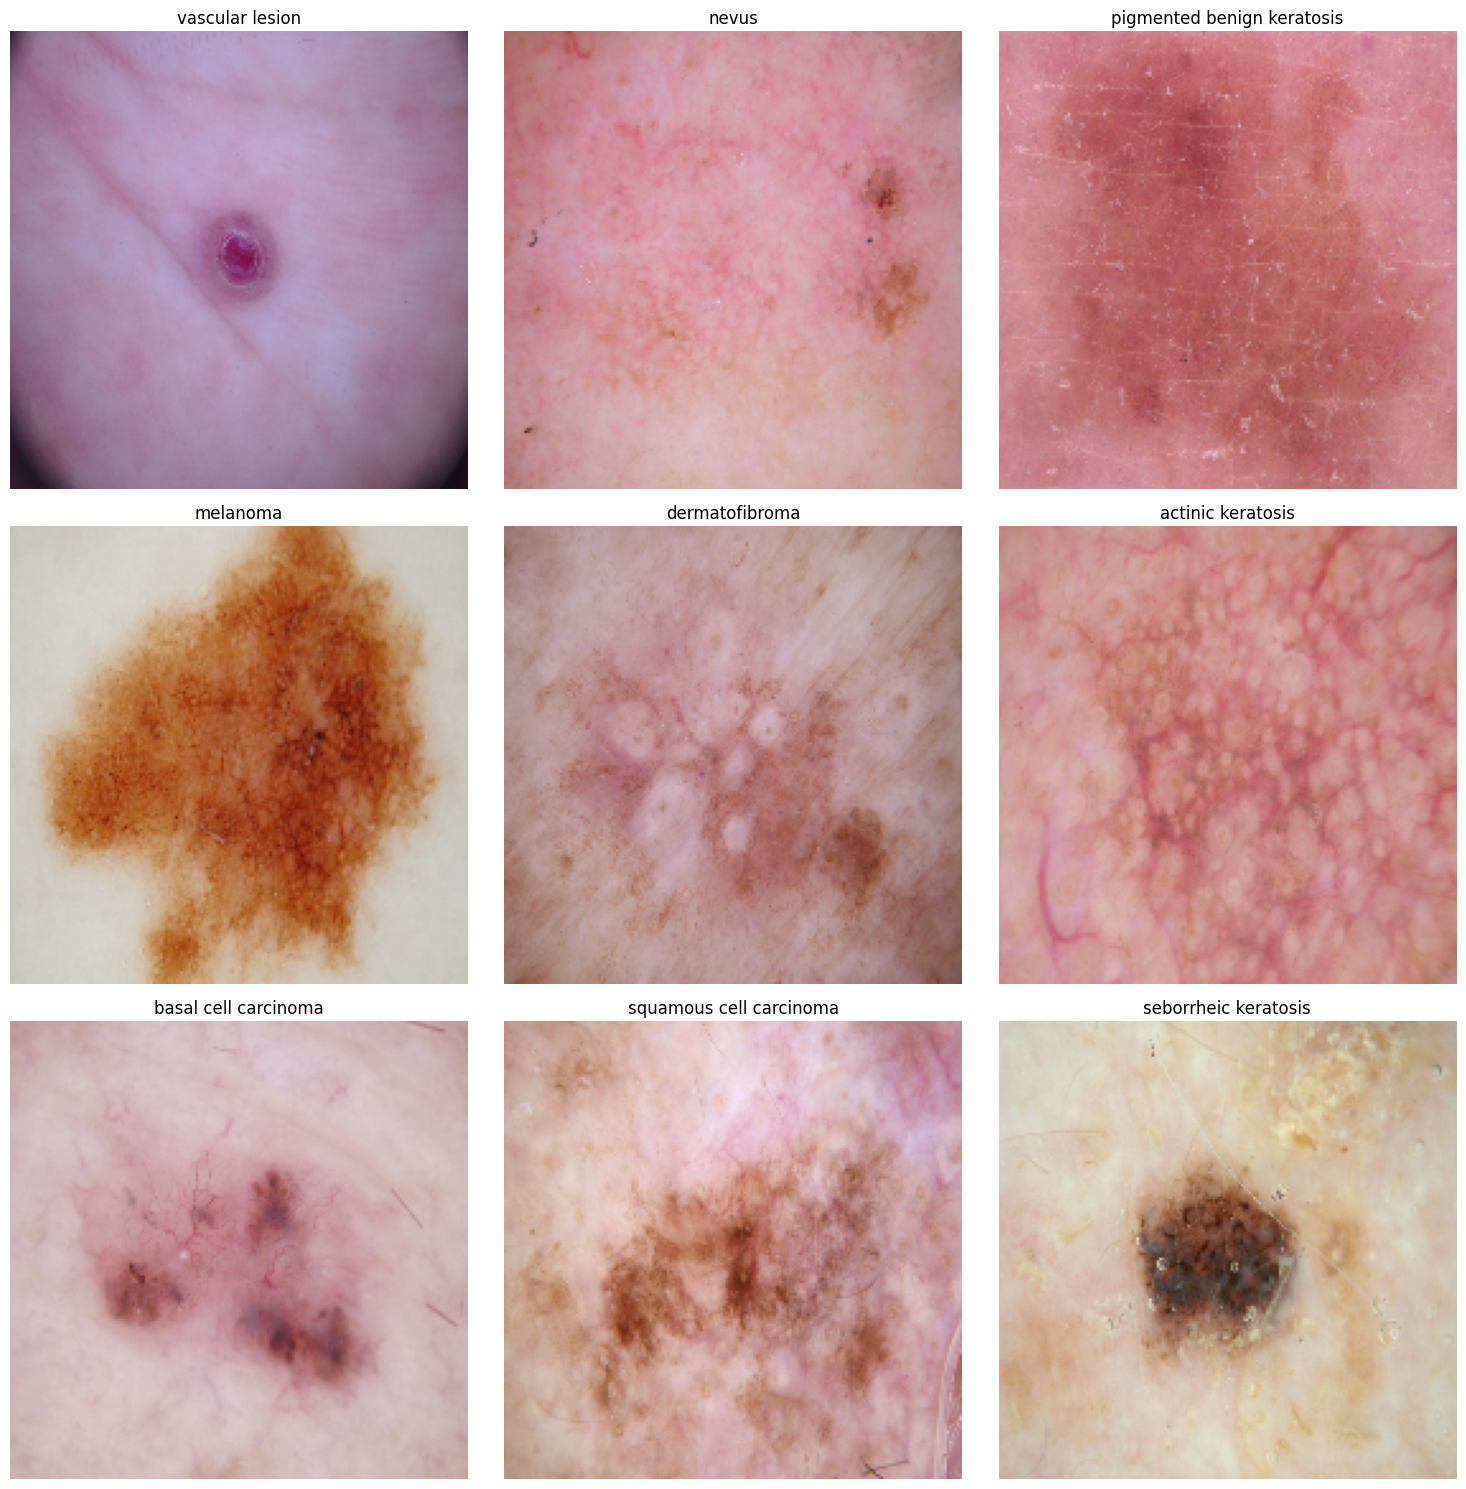

In [ ]:
import matplotlib.pyplot as plt

def visualize_class(dataset, class_names, num_classes=9):
  plt.figure(figsize=(15, 15))

  # Dictionary to store one example per class
  class_examples = {}

  # Iterate through the dataset to collect one example per class
  for images, labels in train_ds:
    for image, label in zip(images, labels):
      # Get the index of the maximum value (representing the class)
      class_index = tf.argmax(label).numpy()
      class_name = class_names[class_index]
      if class_name not in class_examples:
        class_examples[class_name] = image
      if len(class_examples) == num_classes:
        break
    if len(class_examples) == num_classes:
      break

  # Plotting the examples
  for idx, (class_name, image) in enumerate(class_examples.items(), 1):
    plt.subplot(3, 3, idx)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")
  plt.tight_layout()
  plt.show()

# Using Tranning Dataset
visualize_class(
    train_ds,
    class_names,
    num_classes=9
)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

The error you're encountering is due to the use of the experimental module, which is no longer available in recent versions of TensorFlow/Keras.

In [ ]:
model = models.Sequential([
    Input(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(8, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(9, activation='softmax')  # Assuming 9 classes for classification
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 53792)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       1,721,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             297 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,727,705 (6.59 MB)

 Trainable params: 1,727,705 (6.59 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    shuffle=True
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.1887 - loss: 2.2006 - val_accuracy: 0.3557 - val_loss: 1.8407
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.3620 - loss: 1.8207 - val_accuracy: 0.3714 - val_loss: 1.6781
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3872 - loss: 1.6884 - val_accuracy: 0.4720 - val_loss: 1.5799
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4464 - loss: 1.5742 - val_accuracy: 0.4407 - val_loss: 1.5945
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5004 - loss: 1.4543 - val_accuracy: 0.5391 - val_loss: 1.4003
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5558 - loss: 1.3373 - val_accuracy: 0.5123 - val_loss: 1.4168
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5572 - loss: 1.2819 - val_accuracy: 0.5414 - val_loss: 1.3818
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5695 - loss: 1.2399 - val_accuracy: 0.5257 - 

### Visualizing training results

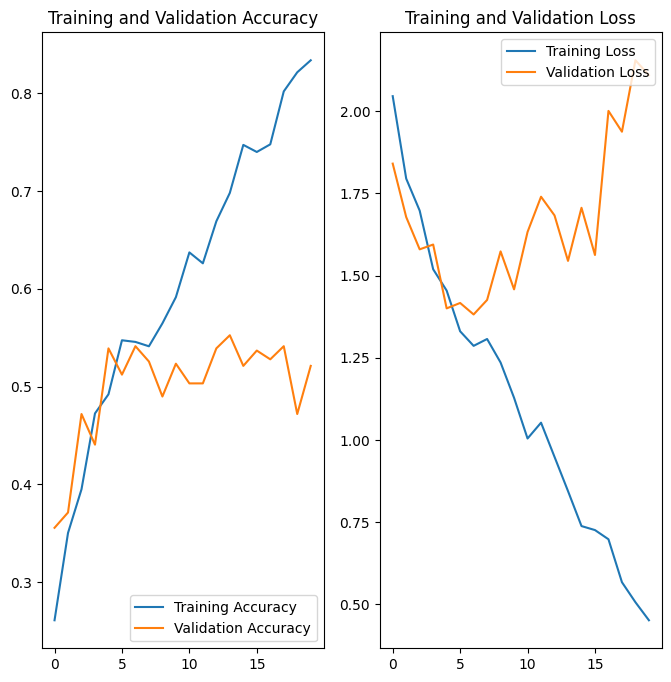

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### The training accuracy continues to rise while the validation accuracy stagnates or even decreases.
The training loss decreases, but the validation loss increases towards the end, showing the model is overfitting the training data. It has learned patterns in the training data but fails to generalize to new, unseen data.

Conclusion: The model is overfitting due to memorizing the training data instead of learning generalizable features.

In [ ]:
# Define the augmentation model
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # Flip images horizontally
    layers.RandomRotation(0.5),       # Increase random rotation
    layers.RandomZoom(0.5),           # Increase random zoom
])

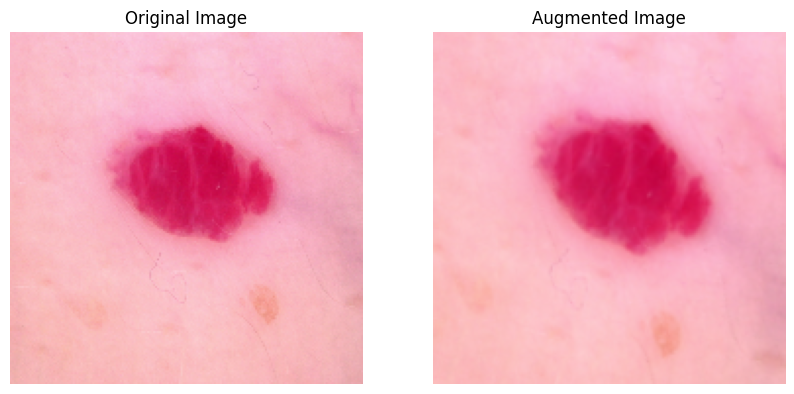

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of images from the training dataset
for images, labels in train_ds.take(1):  # Take one batch
    sample_image = images[0].numpy()  # Convert Tensor to NumPy array

# Apply the augmentation model to the sample image
augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
augmented_image = augmented_image[0].numpy()  # Convert Tensor to NumPy array

# Ensure the images are scaled between 0 and 1
sample_image = sample_image - sample_image.min()
sample_image = sample_image / sample_image.max()

augmented_image = augmented_image - augmented_image.min()
augmented_image = augmented_image / augmented_image.max()

# Plot the original and augmented images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(sample_image)  # Ensure it's scaled correctly
plt.title("Original Image")
plt.axis('off')

# Augmented image
plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.title("Augmented Image")
plt.axis('off')

plt.show()


In [ ]:
model = tf.keras.Sequential([
    Input(shape=(img_height, img_width, 3)),
    data_augmentation, # Data Augmentation
    layers.Rescaling(1./255),

    layers.Conv2D(8, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9-class classification
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history2 = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    shuffle=True
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.1844 - loss: 2.0822 - val_accuracy: 0.2707 - val_loss: 1.9979
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3157 - loss: 1.9149 - val_accuracy: 0.3893 - val_loss: 1.7078
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4028 - loss: 1.6358 - val_accuracy: 0.4228 - val_loss: 1.6795
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4529 - loss: 1.5624 - val_accuracy: 0.4787 - val_loss: 1.5149
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4556 - loss: 1.5020 - val_accuracy: 0.4541 - val_loss: 1.5399
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4929 - loss: 1.4303 - val_accuracy: 0.4765 - val_loss: 1.4588
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4964 - loss: 1.4057 - val_accuracy: 0.4609 - val_loss: 1.5414
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4807 - loss: 1.4382 - val_accuracy: 0.5145 - v

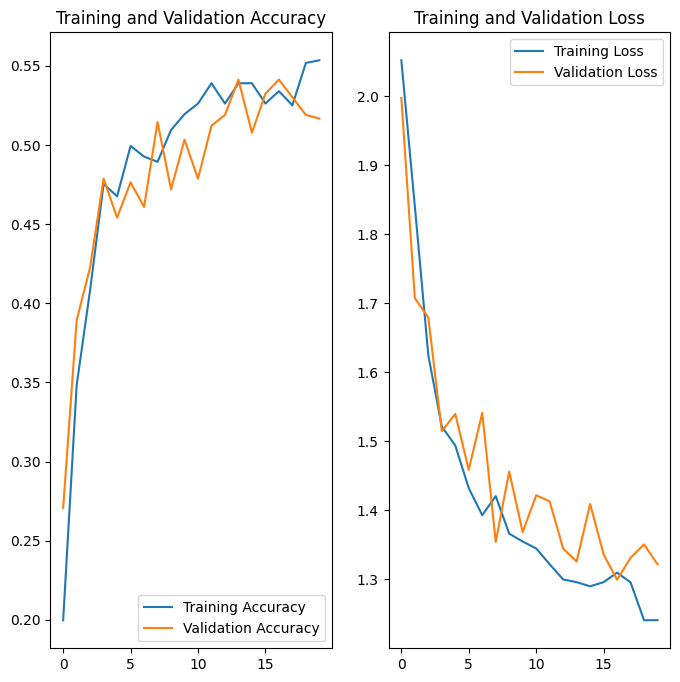

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = tf.keras.Sequential([
    Input(shape=(img_height, img_width, 3)),
    data_augmentation, # Data Augmentation
    layers.Rescaling(1./255),

    layers.Conv2D(8, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9-class classification
])



### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [ ]:
history3 = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    shuffle=True
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2293 - loss: 2.0352 - val_accuracy: 0.3468 - val_loss: 1.8673
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3886 - loss: 1.6817 - val_accuracy: 0.3647 - val_loss: 1.7954
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4194 - loss: 1.5935 - val_accuracy: 0.4116 - val_loss: 1.6936
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4532 - loss: 1.6067 - val_accuracy: 0.4318 - val_loss: 1.6530
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4731 - loss: 1.4867 - val_accuracy: 0.4609 - val_loss: 1.5903
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4616 - loss: 1.4785 - val_accuracy: 0.4810 - val_loss: 1.5281
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4553 - loss: 1.4983 - val_accuracy: 0.4922 - val_loss: 1.4930
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4938 - loss: 1.4612 - val_accuracy: 0.4989 - v

### Visualizing the results

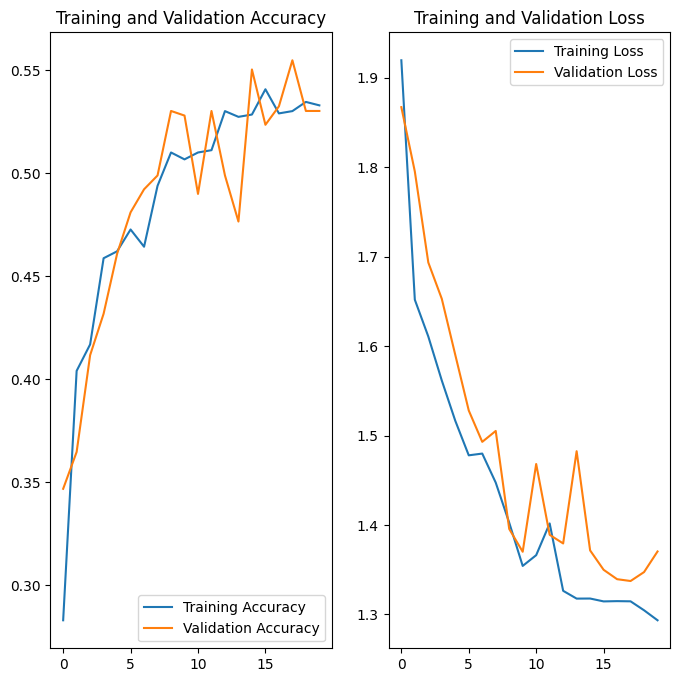

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model with dropout layers does seem to show better performance compared to the previous model without dropout. Although both models experienced fluctuations in accuracy and loss, adding dropout helped to stabilize the results and avoid a sharp overfitting trend seen in models with no regularization.

The validation accuracy is higher and more stable with the addition of dropout, though it still fluctuates. This indicates that dropout is having a positive effect on regularization but more fine-tuning may be needed for further improvement.

#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

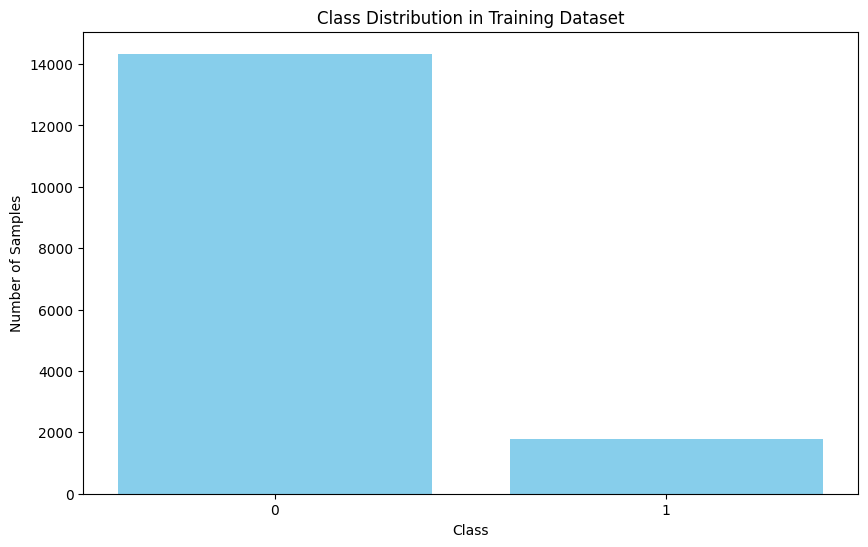

Class Distribution: {0.0: 14336, 1.0: 1792}


In [ ]:
# Assuming you have the train_dataset with labels available
class_labels = []

# Iterate through the training dataset and collect labels
for images, labels in train_ds:
    class_labels.extend(labels.numpy())

# Convert to numpy array and count the occurrences of each class
class_labels = np.array(class_labels)
unique, counts = np.unique(class_labels, return_counts=True)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.xticks(unique)
plt.show()

# Optionally, print the class distribution
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

#### - Class 1 has the least amount of samples
#### - Class 0 dominates the amount of samples


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset=pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x789520F9BC50>: 100%|██████████| 500/500 [00:18<00:00, 26.98 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x789520D23A90>: 100%|██████████| 500/500 [00:16<00:00, 30.57 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x789520D44550>: 100%|██████████| 500/500 [00:17<00:00, 28.73 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7895405194D0>: 100%|██████████| 500/500 [01:22<00:00,  6.06 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7895405A3910>: 100%|██████████| 500/500 [01:10<00:00,  7.12 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7895405A3910>: 100%|██████████| 500/500 [00:17<00:00, 29.27 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7895382247D0>: 100%|██████████| 500/500 [00:38<00:00, 12.92 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789520F67A10>: 100%|██████████| 500/500 [00:16<00:00, 29.84 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7895405EDF90>: 100%|██████████| 500/500 [00:16<00:00, 29.90 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
original_df = pd.DataFrame(columns=['Path', 'Label'])
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [ ]:
new_df['Label'].value_counts()

,count
Label,
actinic keratosis,500
dermatofibroma,500
melanoma,500
basal cell carcinoma,500
seborrheic keratosis,500
vascular lesion,500
pigmented benign keratosis,500
squamous cell carcinoma,500
nevus,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
data_dir_train=pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), depth=9)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), depth=9)))

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),   # Horizontal flip
    layers.RandomRotation(0.2),        # Reduce rotation to prevent excessive distortion
    layers.RandomZoom(0.2),            # Moderate zoom to keep object visibility
    layers.RandomBrightness(0.2),      # Adjust brightness slightly for lighting variations
    layers.RandomContrast(0.2)         # Add contrast variation
])

#### Create your model (including normalization)

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = tf.keras.Sequential([
    Input(shape=(img_height, img_width, 3)),
    data_augmentation, # Data Augmentation
    layers.Rescaling(1./255),

    layers.Conv2D(8, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')  # 9-class classification
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
# Compile Model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_11 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 178, 178, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 89, 89, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 87, 87, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 43, 43, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 41, 41, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 41, 41, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │         819,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 826,009 (3.15 MB)

 Trainable params: 825,945 (3.15 MB)

 Non-trainable params: 64 (256.00 B)

#### Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history4 = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 99s 236ms/step - accuracy: 0.1500 - loss: 2.5825 - val_accuracy: 0.1403 - val_loss: 2.2187
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 215ms/step - accuracy: 0.2852 - loss: 1.9016 - val_accuracy: 0.2420 - val_loss: 2.0160
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 237ms/step - accuracy: 0.3310 - loss: 1.7440 - val_accuracy: 0.2331 - val_loss: 1.9369
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - accuracy: 0.3503 - loss: 1.7004 - val_accuracy: 0.2977 - val_loss: 1.7147
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 238ms/step - accuracy: 0.3684 - loss: 1.6764 - val_accuracy: 0.4261 - val_loss: 1.5267
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 243ms/step - accuracy: 0.3784 - loss: 1.6391 - val_accuracy: 0.3660 - val_loss: 1.5993
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 76s 208ms/step - accuracy: 0.3827 - loss: 1.6455 - val_accuracy: 0.3400 - val_loss: 1.7009
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 235ms/step - accuracy: 0.3718 - loss: 1

###  Visualize the model results

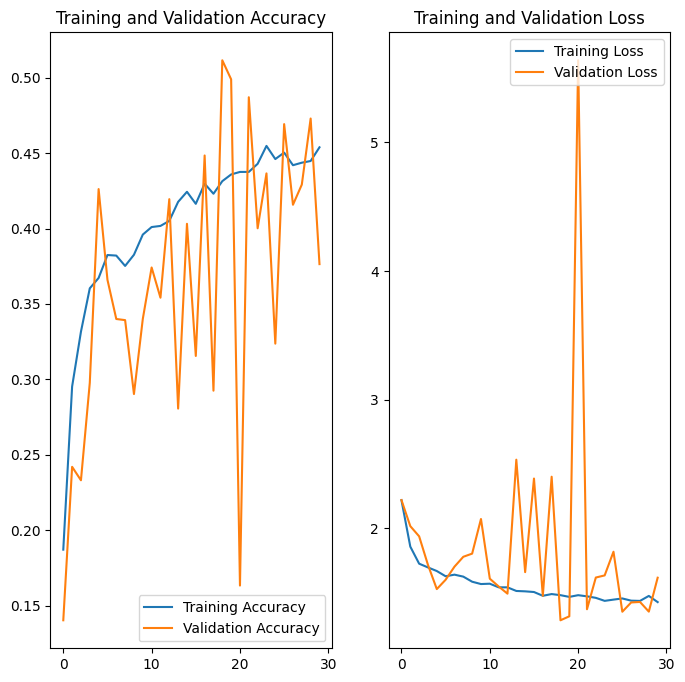

In [76]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [77]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
])

# Define model
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),

    # Data augmentation (only applied during training)
    data_augmentation,

    # Preprocessing
    layers.Rescaling(1./255),

    # First Conv Block
    layers.Conv2D(16, (3,3), activation='relu', padding='same',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    # Second Conv Block
    layers.Conv2D(32, (3,3), activation='relu', padding='same',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.SpatialDropout2D(0.3),  # Spatial dropout instead of regular dropout

    # Third Conv Block
    layers.Conv2D(48, (3,3), activation='relu', padding='same',  # Reduced from 64 to 48
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.SpatialDropout2D(0.4),

    # Dense layers
    layers.Flatten(),
    layers.Dense(96, activation='relu',   # Reduced from 128 to 96
                kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')  # 9-class classification
])

# Compile with a slightly lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Reduced from 0.001
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

# Training with callbacks
epochs = 50  # Increase max epochs, early stopping will prevent overfitting

history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]  # Add callbacks
)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_12 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d (SpatialDropout2D) │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 45, 45, 48)          │          13,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 45, 45, 48)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 22, 22, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_1                  │ (None, 22, 22, 48)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 23232)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 96)                  │       2,230,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 96)                  │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 9)                   │             873 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,250,969 (8.59 MB)

 Trainable params: 2,250,585 (8.59 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 256ms/step - accuracy: 0.1862 - loss: 3.0342 - val_accuracy: 0.1039 - val_loss: 2.7488 - learning_rate: 5.0000e-04
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 226ms/step - accuracy: 0.3105 - loss: 2.3058 - val_accuracy: 0.2294 - val_loss: 2.2225 - learning_rate: 5.0000e-04
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 250ms/step - accuracy: 0.3400 - loss: 2.1562 - val_accuracy: 0.3445 - val_loss: 2.0782 - learning_rate: 5.0000e-04
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 236ms/step - accuracy: 0.3612 - loss: 2.0454 - val_accuracy: 0.4187 - val_loss: 1.7484 - learning_rate: 5.0000e-04
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 235ms/step - accuracy: 0.3780 - loss: 1.9674 - val_accuracy: 0.4588 - val_loss: 1.6487 - learning_rate: 5.0000e-04
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.3846 - loss: 1.9254 - val_accuracy: 0.4336 - val_loss: 1.7440 - learning_rate: 5.0000e-04
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 22

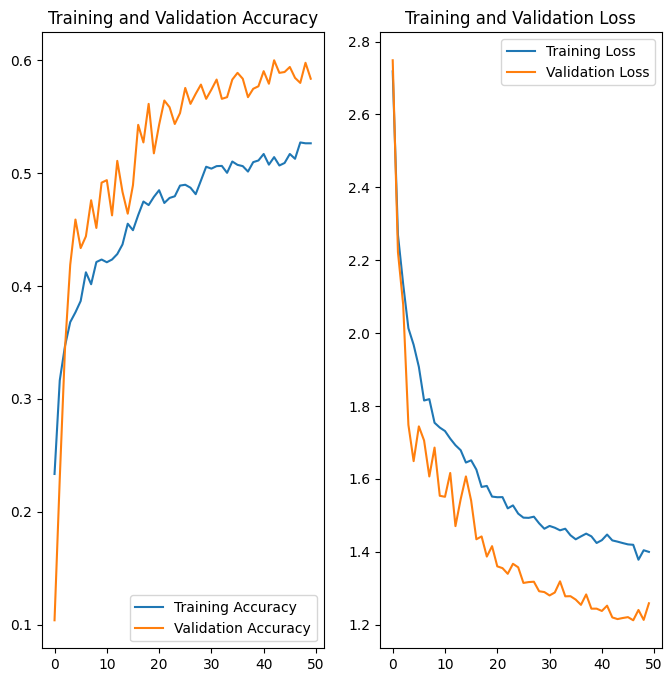

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Positive Changes

1. Reduced Overfitting: The gap between training accuracy (~51%) and validation accuracy (~59%) is much smaller now, which shows the regularization techniques are working.
2. Stable Validation Loss: The validation loss is consistently decreasing without major spikes, indicating better generalization.

3.Learning Rate Adaptation: The learning rate reduction at epoch 17 (from 5e-4 to 1e-4) helped stabilize training.

Areas for Improvement

1. Overall Accuracy: Both training and validation accuracy have plateaued at around 50-59%, which is still relatively low for a 9-class classification problem.
2. Slow Convergence: The model is improving very slowly after epoch 30, suggesting we might need a different approach.
